In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision import utils

import numpy as np
import random

# For working with MATLAB data
import scipy.io as spio

# For plotting
import matplotlib.pyplot as plt

# Set seed
random.seed(1)

# Load data

In [62]:
# Setup the dataset class
class gaborDataset(Dataset):
    """Gabor Patches dataset."""

    def __init__(self, mat_file, train=True, transform=None):
        """
        Args:
            mat_file (string): Path to the .mat file (includes samplesCrop and labels variables).
            root_dir (string): Directory with the .mat file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        # Whether to use training set or test set
        self.train = train  
        
        # We don't actually need this atm, but let's keep it around just in case. 
        self.transform = transform
        
        # Read the data
        mat = spio.loadmat(mat_file)
        
        # Assume the mat contains the following:
        trainImages = mat['trainImages'] 
        trainLabels = mat['trainLabels'] 
        trainContrasts = mat['trainContrasts']
        trainFreqs = mat['trainFreqs']
        testImages = mat['testImages'] 
        testLabels = mat['testLabels'] 
        testContrasts = mat['testContrasts']
        testFreqs = mat['testFreqs']
        
        nTrain = len(trainLabels)
        nTest = len(testLabels)
        
        # Normalize the training set
        meanTrain = np.mean(trainImages)
        stdTrain = np.std(trainImages)
        trainImages = (trainImages - meanTrain)/stdTrain
        
        # Also normalize the test set but use the mean/std from training set
        testImages = (testImages - meanTrain)/stdTrain
        
        # Use different data depending on whether we want the training or testing data
        if self.train:
            self.images = trainImages
            self.labels = np.squeeze(trainLabels)
            self.contrasts = np.squeeze(trainContrasts)
            self.freqs = np.squeeze(trainFreqs)
        else:
            self.images = testImages
            self.labels = np.squeeze(testLabels)
            self.contrasts = np.squeeze(testContrasts)
            self.freqs = np.squeeze(testFreqs)
            
    def __len__(self):   
        return len(self.labels)

    def __getitem__(self, idx):
        

        image = self.images[:,:,idx]
    
        # Easier to work with HxWxC
        image = np.expand_dims(image, axis=2)
        image = T.ToTensor()(image)
        
        sample = {'image': image, 'label': self.labels[idx],
                  'contrast': self.contrasts[idx], 'freq':self.freqs[idx]}
    
        if self.transform:
            sample = self.transform(sample)

        return sample

TRAINING SET
Number of images: 10000


/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


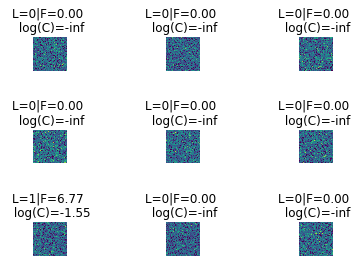

In [63]:
# Veirfy the gaborDataset class is working correctly

gabor_dataset = gaborDataset('trainingAndTestSet_v2.mat',train=True)

fig = plt.figure()
  
print("TRAINING SET")    
print('Number of images: %i' % len(gabor_dataset))

for i in range(0,9):
    
    imSelect = random.randint(0,len(gabor_dataset)-1)
    sample = gabor_dataset[imSelect]
    
    ax = plt.subplot(3, 3, i + 1)
    plt.tight_layout()
    ax.set_title("L=%i|F=%0.2f \n log(C)=%0.2f" % (sample['label'],
                                                sample['freq'],
                                                   np.log10(sample['contrast'])))
    ax.axis('off')
    plt.imshow(np.squeeze(sample['image']))
   

TEST SET
Number of images: 10000


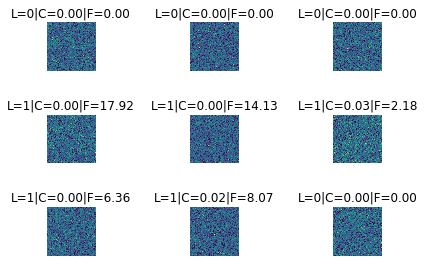

In [64]:
test_dataset = gaborDataset('trainingAndTestSet_v2.mat',train=False)

fig = plt.figure()
  
print("TEST SET")    
print('Number of images: %i' % len(gabor_dataset))

for i in range(0,9):
    
    imSelect = random.randint(0,len(gabor_dataset)-1)
    sample = gabor_dataset[imSelect]
    
    ax = plt.subplot(3, 3, i + 1)
    plt.tight_layout()
    ax.set_title("L=%i|C=%0.2f|F=%0.2f" % (sample['label'],sample['contrast'],sample['freq']))
    ax.axis('off')
    plt.imshow(np.squeeze(sample['image']))
    

In [65]:
# Use the GPU if it's available

USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 1

print('using device:', device)

using device: cpu


In [66]:
# Calculate mean and std of dataset
# TODO: Do we need to do this?

In [67]:
NUM_TRAIN = 4500
NUM_VAL = 500

if((NUM_TRAIN+NUM_VAL) > len(train_dataset)):
    print("NUM_TRAIN+NUM_VAL greater than size of dataset: %i" % len(gabor_dataset))
    
if((NUM_TRAIN+NUM_VAL) < len(train_dataset)):
    print("NUM_TRAIN+NUM_VAL is less than size of dataset: %i" % len(gabor_dataset))


# TL NOTE: Leaving out normalization for now. 
# transform = T.Compose([
#                T.ToTensor(),
#                 T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#                 T.Normalize((31.5),(18.23))
#             ])

gabor_train = gaborDataset('trainingAndTestSet_v2.mat',train=True)
loader_train = DataLoader(gabor_train, batch_size=100, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

gabor_val = gaborDataset('trainingAndTestSet_v2.mat',train=True)
loader_val = DataLoader(gabor_val, batch_size=100, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TRAIN + NUM_VAL)))

# Helper function to show a batch
def show_batch(sample_batched):
    """Show image with label for a batch of samples."""
    images_batch, label_batch = \
            sample_batched['image'], sample_batched['label']
    batch_size = len(images_batch)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid[1,:,:])
    plt.title('Batch from dataloader')

NUM_TRAIN+NUM_VAL is less than size of dataset: 10000


Training Set:
0 torch.Size([100, 1, 128, 128])


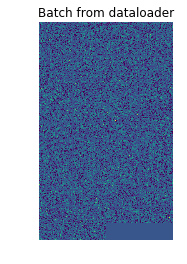

1 torch.Size([100, 1, 128, 128])


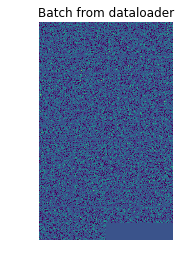

Validation Set:
0 torch.Size([100, 1, 128, 128])


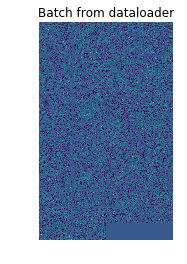

1 torch.Size([100, 1, 128, 128])


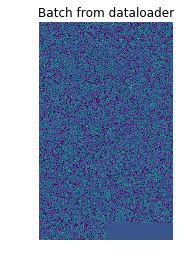

In [68]:
# Show a few batches:
print("Training Set:")
for i_batch, sample_batched in enumerate(loader_train):
    print(i_batch, sample_batched['image'].size())

    # observe first two batches
    if i_batch == 0:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        
    if i_batch == 1:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break
        
print("Validation Set:")
for i_batch, sample_batched in enumerate(loader_val):
    print(i_batch, sample_batched['image'].size())

    # observe first two batches
    if i_batch == 0:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        
    if i_batch == 1:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break
        

# Start training
Try a basic 2-layer ConvNet from the homework

In [69]:
import torch.nn.functional as F  # useful stateless functions

def train_part34(model, optimizer, epochs=1):
    """
    Train a model using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: 
    - lossOutput: loss values as a list 
    """
    lossHistory = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        
        for t, sample_batched in enumerate(loader_train): 

            x, y = sample_batched['image'], sample_batched['label']      
            
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            y = np.squeeze(y)
            
            scores = model(x)
            
            loss = F.cross_entropy(scores, y)
            
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()
            
            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()
            
            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                lossHistory.append(loss.item())
                check_accuracy_part34(loader_val, model)
                print()
                
        return lossHistory

In [70]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    
    correct_freq = []
    incorrect_freq = []
    correct_contrast = []
    incorrect_contrast = []

    falsePos = 0
    falseNeg = 0
    
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for sample_batched in loader:
            x, y, c, f = (sample_batched['image'], sample_batched['label'],
                          sample_batched['contrast'],sample_batched['freq'])
            
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            
            falsePos += ((preds != y) & (y == 0)).sum()
            falseNeg += ((preds != y) & (y == 1)).sum()
            
            if(loader.dataset.train == False):
                correct_freq.append(f[(preds == y) & (y == 1)])
                incorrect_freq.append(f[(preds != y) & (y == 1)])
                
        acc = float(num_correct) / num_samples
        falseNegPerc = float(falseNeg) / float(num_samples-num_correct)
        falsePosPerc = float(falsePos) / float(num_samples-num_correct)
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print('False negative: %d/%d (%0.2f)' % (falseNeg,num_samples-num_correct,100*falseNegPerc))
        print('False positive: %d/%d (%0.2f)' % (falsePos,num_samples-num_correct,100*falsePosPerc))
        
        return correct_freq, incorrect_freq

In [52]:
# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        N = x.shape[0] # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

learning_rate = 0.5e-2 #5e-2

model = None
optimizer = None
       
model = nn.Sequential(
    
    nn.Conv2d(1,6,5), # (128-5+0)/1 + 1 = 124
    nn.ReLU(),
    nn.MaxPool2d(2,2), # 124/2 = 62
    nn.Conv2d(6,16,5), # (62-5+0)/1 + 1 = 58
    nn.ReLU(),
    nn.MaxPool2d(2,2), # 58/2 = 29
    Flatten(),
    nn.Linear(29*29*16,120), 
    nn.ReLU(),
    nn.Linear(120,84),
    nn.ReLU(),
    nn.Linear(84,2)
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

lossHistory = train_part34(model, optimizer,epochs=20)

Iteration 0, loss = 0.6922
Checking accuracy on validation set
Got 250 / 500 correct (50.00)
False negative: 0/250 (0.00)
False positive: 250/250 (100.00)

Iteration 1, loss = 0.6830
Checking accuracy on validation set
Got 250 / 500 correct (50.00)
False negative: 0/250 (0.00)
False positive: 250/250 (100.00)

Iteration 2, loss = 0.7162
Checking accuracy on validation set
Got 250 / 500 correct (50.00)
False negative: 0/250 (0.00)
False positive: 250/250 (100.00)

Iteration 3, loss = 0.6919
Checking accuracy on validation set
Got 250 / 500 correct (50.00)
False negative: 0/250 (0.00)
False positive: 250/250 (100.00)

Iteration 4, loss = 0.6976
Checking accuracy on validation set
Got 247 / 500 correct (49.40)
False negative: 3/253 (1.19)
False positive: 250/253 (98.81)

Iteration 5, loss = 0.6959
Checking accuracy on validation set
Got 269 / 500 correct (53.80)
False negative: 222/231 (96.10)
False positive: 9/231 (3.90)

Iteration 6, loss = 0.6916
Checking accuracy on validation set
Got

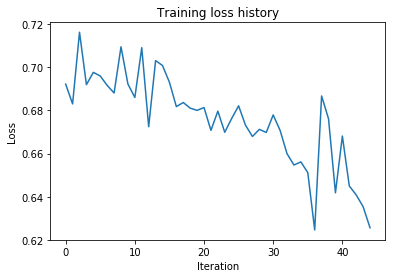

In [57]:
plt.plot(lossHistory)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

In [54]:
# Loading test set
gabor_test = gaborDataset('trainingAndTestSet_v2.mat',train=False)

# Load all data in a single batch
loader_test = DataLoader(gabor_test, batch_size=len(gabor_test))


In [59]:
# Check the accuracy with the specific test set we are using.
def CSFtest(loader, model):
    if loader.dataset.train:
        print('Loader given was for training. Exiting.')
        return
    else:
        print('Checking accuracy on test set')   

    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for sample_batched in loader:
            x, y, c, f = (sample_batched['image'], sample_batched['label'],
                          sample_batched['contrast'],sample_batched['freq'])
            
            # Assume we've loaded the entire dataset in a single batch
            if(len(c) != len(loader.dataset)):
                print("Error with batch size. Batch size was %i. Loader size was %i. Exiting."
                     % (len(c),len(loader.dataset)))
                return
            
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)

            correct = (preds == y)
            
            # Calculate percent correct for each frequency and contrast
            unique_c = np.unique(c)
            unique_f = np.unique(f)
            num_c = len(unique_c)
            num_f = len(unique_f)
            num_comb = num_c*num_f
            
            # Initialize results matrix
            results = np.zeros((num_comb,3))
            k = 0
            for cc in unique_c:
                for ff in unique_f:
                    
                    print("")
                    print("contrast = %0.4f" % cc)
                    print("freq = %0.4f" % ff)
                    
                    curr_i = ((c == cc) & (f == ff))
                    
                    print("preds:")
                    print(preds[curr_i])
                    
                    print("y:")
                    print(y[curr_i])
                    
                    print("correct:")
                    print(correct[curr_i])
                    
                    num_correct = (correct[curr_i]).sum()
                    num_total = len((correct[curr_i]))
                    results[k,0] = cc
                    results[k,1] = ff
                    results[k,2] = float(num_correct) / float(num_total)
                    k += 1

        
        return results

Checking accuracy on test set

contrast = 0.0003
freq = 1.9953
preds:
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0])
y:
tensor([ 1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,
         1,  0,  1,  0,  1,  0])
correct:
tensor([ 0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,
         0,  1,  0,  1,  0,  1], dtype=torch.uint8)

contrast = 0.0003
freq = 3.9811
preds:
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0])
y:
tensor([ 1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,
         1,  0,  1,  0,  1,  0])
correct:
tensor([ 0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,
         0,  1,  0,  1,  0,  1], dtype=torch.uint8)

contrast = 0.0003
freq = 7.9433
preds:
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0])
y:
tensor([ 1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,
         1,  0,  1,  0,  1,  0])
correct:


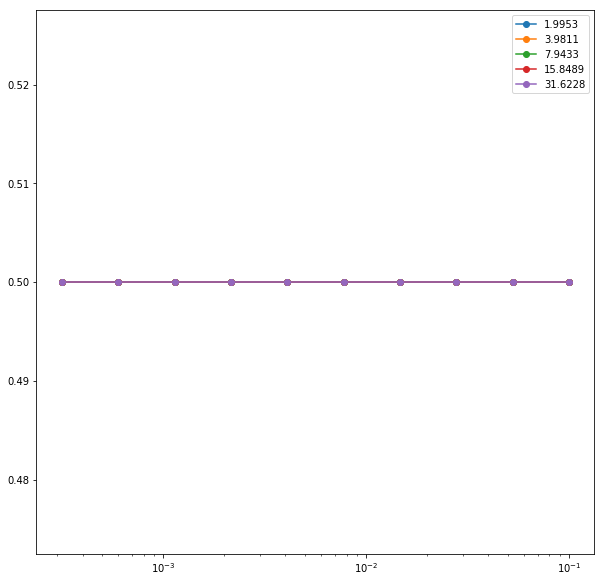

In [60]:
best_model = model
results = CSFtest(loader_test, best_model)

# print(results)

# Plot the results
unique_c = np.unique(results[:,0])
unique_f = np.unique(results[:,1])

plt.figure(figsize=(10,10))

for ff in unique_f:
    curr_i = (results[:,1]==ff)
    curr_c = results[curr_i,0]
    curr_acc = results[curr_i,2]
    plt.plot(curr_c,curr_acc,'o-',label=('%0.4f' % ff))
    
plt.legend()
plt.xscale('log')


In [21]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Make input tensor require gradient
    X.requires_grad_()
    
    saliency = None
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores (we'll combine losses across a batch by summing), and then compute  #
    # the gradients with a backward pass.                                        #
    ##############################################################################
    scores = model(X)
    N,C = scores.shape
    
    correct_scores = scores.gather(1, y.view(-1, 1)).squeeze()
    
    model.zero_grad()
    
    # Backward pass
    num_images = correct_scores.shape
    correct_scores.backward(torch.ones([num_images[0]]))
    saliency = torch.abs(torch.sum(X.grad, dim=1))
    
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency



RuntimeError: expected stride to be a single integer value or a list of 1 values to match the convolution dimensions, but got stride=[1, 1]

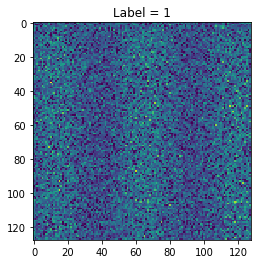

In [22]:

# sample = gabor_dataset[10]

# X = sample['image']
# y = sample['label']

# plt.imshow(np.squeeze(X))
# plt.title("Label = %d" % y)

# saliency = compute_saliency_maps(X, y, best_model)
# plt.imshow(saliency)
    
# def show_saliency_maps(X, y):
#     # Convert X and y from numpy arrays to Torch Tensors
#     X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
#     y_tensor = torch.LongTensor(y)

#     # Compute saliency maps for images in X
#     saliency = compute_saliency_maps(X_tensor, y_tensor, model)

#     # Convert the saliency map from Torch Tensor to numpy array and show images
#     # and saliency maps together.
#     saliency = saliency.numpy()
#     N = X.shape[0]
#     for i in range(N):
#         plt.subplot(2, N, i + 1)
#         plt.imshow(X[i])
#         plt.axis('off')
#         plt.title(class_names[y[i]])
#         plt.subplot(2, N, N + i + 1)
#         plt.imshow(saliency[i], cmap=plt.cm.hot)
#         plt.axis('off')
#         plt.gcf().set_size_inches(12, 5)
#     plt.show()

# show_saliency_maps(X, y)

In [143]:
# Visualize weights
# From: https://github.com/pedrodiamel/nettutorial/blob/master/pytorch/pytorch_visualization.ipynb

def vistensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    '''
    vistensor: visuzlization tensor
        @ch: visualization channel 
        @allkernels: visualization all tensores
    ''' 
    
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1,w,h )
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
        
    rows = np.min( (tensor.shape[0]//nrow + 1, 64 )  )    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

def savetensor(tensor, filename, ch=0, allkernels=False, nrow=8, padding=2):
    '''
    savetensor: save tensor
        @filename: file name
        @ch: visualization channel 
        @allkernels: visualization all tensores
    '''    

    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1,w,h )
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)    
    utils.save_image(tensor, filename, nrow=nrow )

In [103]:

for layer in best_model.modules():
   if isinstance(layer, nn.Linear):                  
        kernel = layer.weight.clone()
        print(kernel.shape)
        kernel = kernel.view((2,1,128,128))
        print(kernel.shape)
        break

vistensor(kernel.data, ch=0, allkernels=False)
# savetensor(kernel,'kernel.png', allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

torch.Size([120, 13456])


RuntimeError: invalid argument 2: size '[2 x 1 x 128 x 128]' is invalid for input with 1614720 elements at /opt/conda/conda-bld/pytorch_1524590031827/work/aten/src/TH/THStorage.c:41